# Relax Challenge

### Data:
The data is available as two attached CSV files:
* takehome_user_engagement. csv
* takehome_users . csv

The data has the following two tables:

1] A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:
* name: the user's name
* object_id: the user's id
* email: email address
* creation_source: how their account was created. This takes on one of 5 values:
   - PERSONAL_PROJECTS: invited to join another user's personal workspace
   - GUEST_INVITE: invited to an organization as a guest (limited permissions)
   - ORG_INVITE: invited to an organization (as a full member)
   - SIGNUP: signed up via the website
   - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
* creation_time: when they created their account
* last_session_creation_time: unix timestamp of last login
* opted_in_to_mailing_list: whether they have opted into receiving marketing emails
* enabled_for_marketing_drip: whether they are on the regular marketing email drip
* org_id: the organization (group of users) they belong to
* invited_by_user_id: which user invited them to join (if applicable).

2] A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.

### The objective:
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday
period , identify which factors predict future user adoption .

## 0.0 Import the libraries

In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

## 1.0 Load data

### 1.1 Load the takehome_user_engagement.csv

In [2]:
engagement = pd.read_csv('./takehome_user_engagement.csv')
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [3]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [5]:
# Check each 'time_stamp' has 1 visit correspondingly.
engagement['visited'].value_counts()

1    207917
Name: visited, dtype: int64

In [6]:
# Check the unique users and the total visits
users_count = engagement['user_id'].nunique()
total_visits = len(engagement)
print(f"This table has {users_count} users for {total_visits} total visits")

This table has 8823 users for 207917 total visits


#### Define a function to find "adopted user" 

In [7]:
# define a function to see if a user logged in on 3 seperate days in a 7-day period.
def adopted_user_checker(df, days=7, logins=3):
    from datetime import timedelta
    # first drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [8]:
# run the function on all users
adopted = engagement.groupby('user_id').apply(adopted_user_checker)
adopted.name = 'adopted_user'

In [9]:
adopted_df = pd.DataFrame(adopted)

In [10]:
adopted_df.head()

,adopted_user
user_id,
1,False
2,True
3,False
4,False
5,False


In [11]:
print(f'There were {sum(adopted)} adopted users out of {len(adopted)} users')

There were 1656 adopted users out of 8823 users


### 1.2 Load the takehome_user.csv

In [12]:
users = pd.read_csv('./takehome_users.csv')

In [13]:
# Change the 'creation_time' to pandas datetime format
users['creation_time'] = pd.to_datetime(users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [14]:
# Change the object_id into user_id to match the other data table
columns = ['user_id', 'creation_time', 'name', 'email', 'creation_source', 
           'last_session_creation_time', 'opted_in_to_mailing_list', 
           'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']

users.columns = columns

# User 'name' and 'email' are private information. They should not be important to predict 'adopted_user'. I am going to drop them now.
users = users.drop(columns=['name', 'email'], axis=1)

# Set "user_id" as index
users.set_index('user_id', inplace=True)

In [15]:
users.head(2)

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
user_id,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0


In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  8823 non-null   datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   org_id                      12000 non-null  int64         
 6   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 750.0+ KB


I am going to add one boolen feature of "invited_by" from "invited_by_user_id". And then drop  "invited_by_user_id".

My suspect is that users invited by others might tend to be frequent users.

In [17]:
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)
#users['invited_by_user_id'].isnull().sum()
users['invited_by'] = 0
for i in range(len(users)):
    if users.iloc[i, 6] > 0: ### 'invited_by_user_id'
        users.iloc[i, 7] = 1  ### "invited_by"

# Now we can safely drop the 'invited_by_user_id' feature
users = users.drop(columns=['invited_by_user_id'], axis=1)

In [18]:
users['invited_by'].value_counts()

1    6417
0    5583
Name: invited_by, dtype: int64

We have 6417 users invited by others to join. And 5583 users joined by themselves.

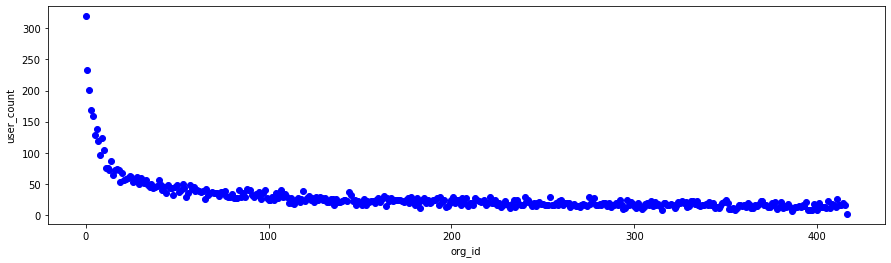

In [19]:
# Now let check "org_id"
df = pd.DataFrame(users.org_id.value_counts())
df.columns = ['user_count']
df.index.name = 'org_id'
df = df.reset_index()

plt.figure(figsize=(15,4))
plt.scatter(df.org_id, df.user_count, color='blue')
plt.xlabel('org_id')
plt.ylabel('user_count')
#plt.grid()
plt.show()

We have more than 400 org_id, and they have different number of users. I don't think "org_id" is important for the modeling. Let's drop it here.

In [20]:
users = users.drop(columns=['org_id'], axis=1)

Let's merge the "adopted_user" with users dataframe.

In [21]:
# Merge user data and "adopted_user" variable
# users = users.set_index('user_id')
users.index.name = 'user_id'
data = pd.concat([users, adopted], axis=1, join = 'inner')
data['adopted_user'] = data['adopted_user'].astype(int)

In [22]:
data.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by,adopted_user
user_id,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,1,0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,1,0
4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,0
5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,1,0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               8823 non-null   datetime64[ns]
 1   creation_source             8823 non-null   object        
 2   last_session_creation_time  8823 non-null   datetime64[ns]
 3   opted_in_to_mailing_list    8823 non-null   int64         
 4   enabled_for_marketing_drip  8823 non-null   int64         
 5   invited_by                  8823 non-null   int64         
 6   adopted_user                8823 non-null   int32         
dtypes: datetime64[ns](2), int32(1), int64(3), object(1)
memory usage: 517.0+ KB


## 2.0 Data EDA and Feature Engineering

### 2.1 Feature Engineering

From the creation time and last session time, we can make two features that can be useful.

In [24]:
# calculate user history, defined as number of days between account creation and last use
data['history'] = data['last_session_creation_time'] - data['creation_time']
data['history'] = data['history'].dt.days
# calculate account age, defined as number of days since account creation and now
# I don't know when this dataset was collected. Let's use the latest date in creation_time
latest = max(data['creation_time'])
data['account_age'] = latest - data['creation_time']
data['account_age'] = data['account_age'].dt.days
# drop the two original columns
data = data.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [25]:
data.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by,adopted_user,history,account_age
user_id,,,,,,,
1,GUEST_INVITE,1,0,1,0,0,38
2,ORG_INVITE,0,0,1,1,136,196
3,ORG_INVITE,0,0,1,0,0,437
4,GUEST_INVITE,0,0,1,0,1,374
5,GUEST_INVITE,0,0,1,0,5,498


### 2.2 EDA

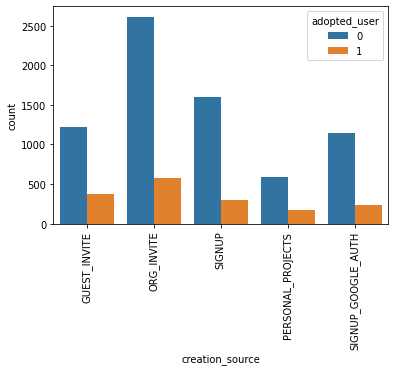

In [27]:
_ = sns.countplot(x='creation_source', data=data, hue='adopted_user')
_ = plt.xticks(rotation=90)

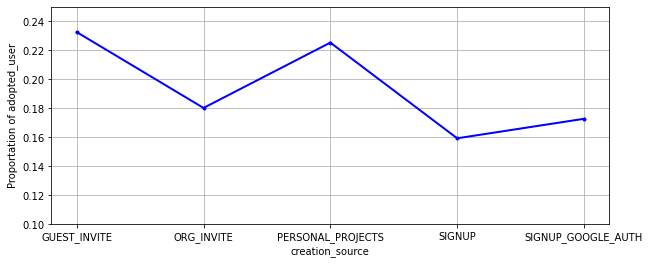

In [42]:
df2 = pd.DataFrame(data.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x)))

plt.figure(figsize=(10,4))
plt.plot(df2.adopted_user, marker='.', color='blue', linewidth=2.0)
plt.xlabel('creation_source')
plt.ylabel('Proportation of adopted_user')
plt.ylim(0.1, 0.25)
plt.grid()
plt.show()

OK, slightly higher "adopted user" rate in guest_invite and personal_projects, that makes sense because users who got invite probably was collaborting with others, and users who have personal projects are likely to have more personal interest that make them more engaged.



In [43]:
# check mailing list and marketing drip
data.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [44]:
data.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

We can see there is no big difference between users who sighed up or not for mailing list and marketing drip.

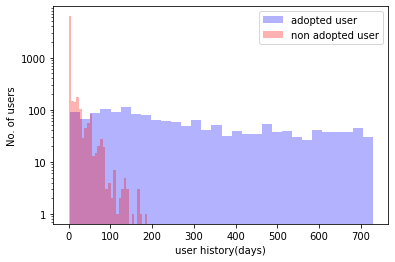

In [47]:
# history and adopted user
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[data['adopted_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[data['adopted_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
    
plot_hist_days(data, 'history', 'user history(days)')

Pretty clear that users with long history are more likely to be adopted users.

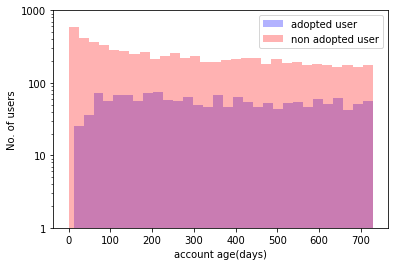

In [46]:
plot_hist_days(data, 'account_age', 'account age(days)')

Not surprisingly, the adoption rate is lower in very new accounts. Other than that, the adoption rate didn't change much over the past two years.

### 2.3 Preprocessing

In [56]:
# Convert "creation_source" to dummy variables
creation_source = pd.get_dummies(data['creation_source'], drop_first=True)
model_data = pd.concat([data, creation_source], axis=1).drop('creation_source', axis=1)

# get the X, y 
y = model_data['adopted_user']
X = model_data.drop('adopted_user', axis=1)

# split the data to train and test sets. Since adopted_user and non adopted_user are not balanced.
# We need to split the data statifiedly.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

## 3.0 Predictive modeling

In [60]:
clf = RandomForestClassifier(class_weight='balanced')

# superparameters
params = {"n_estimators": [100, 200]}

clf_cv = GridSearchCV(clf, params, cv=5)
clf_cv.fit(X_train, y_train)

print('Best parameters were', clf_cv.best_params_)
print('Best average precision was', clf_cv.best_score_)

Best parameters were {'n_estimators': 200}
Best average precision was 0.9619485607221938


In [65]:
# evluation of the model
from sklearn.metrics import classification_report, accuracy_score
clf = RandomForestClassifier(class_weight='balanced', n_estimators=200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy of test set was', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of test set was 0.9569323762750284
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2150
           1       0.90      0.87      0.88       497

    accuracy                           0.96      2647
   macro avg       0.94      0.92      0.93      2647
weighted avg       0.96      0.96      0.96      2647



In [66]:
# take a look at feature importance
imp = pd.Series(clf.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.884945
account_age                   0.093672
opted_in_to_mailing_list      0.004538
enabled_for_marketing_drip    0.004020
ORG_INVITE                    0.003495
SIGNUP                        0.002734
invited_by                    0.002557
PERSONAL_PROJECTS             0.002061
SIGNUP_GOOGLE_AUTH            0.001978
dtype: float64


It is clear that the user history is the most important feature. Account age is the second important one. The next important feature is how user signed up (if you add the importances of the four signup features above). Mailing list and marketing drip are not effective comparatively.